# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [ ]:
# Get helper_functions.py script from GitHub
!wget https://raw.githubusercontent.com/saib7/helper_functions_for_DL_TensorFlow/main/helper_functions.py

--2021-08-07 19:35:15--  https://raw.githubusercontent.com/saib7/helper_functions_for_DL_TensorFlow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10440 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.20K  --.-KB/s    in 0s      

2021-08-07 19:35:15 (98.8 MB/s) - ‘helper_functions.py’ saved [10440/10440]



In [ ]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

Wonderful, now we've got a bunch of helper functions we can use throughout the notebook without having to rewrite them from scratch each time.

> 🔑 **Note:** If we're running this notebook in Google Colab, when it times out Colab will delete the `helper_functions.py` file. So to use the functions imported above, we'll have to rerun the cell.

## 10 Food Classes: Working with less data

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) which is part of the [`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) module.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-08-07 19:35:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   257MB/s    in 0.6s    

2021-08-07 19:35:18 (257 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class. And while this works well and is still very commonly used, this time we're going to use the `image_data_from_directory` function.

It works much the same way as `ImageDataGenerator`'s `flow_from_directory` method meaning your images need to be in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

Let's see it in action.

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# checkout the class names ofour data
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)


tf.Tensor(
[[[[5.86122475e+01 4.96122475e+01 3.28673477e+01]
   [6.24336739e+01 5.04336739e+01 3.44336739e+01]
   [6.92704086e+01 5.45714302e+01 3.80663261e+01]
   ...
   [3.40511589e+01 5.91844845e+00 1.72756557e+01]
   [4.20867882e+01 7.94390678e+00 2.19439068e+01]
   [4.69285355e+01 8.92853642e+00 2.39285374e+01]]

  [[6.74540863e+01 5.54285698e+01 4.23112259e+01]
   [6.42040863e+01 5.10663261e+01 3.54897919e+01]
   [6.61020432e+01 4.98877525e+01 3.46734657e+01]
   ...
   [3.99134865e+01 1.06429882e+01 2.04848480e+01]
   [5.39795341e+01 2.05662346e+01 3.17040005e+01]
   [4.74082031e+01 9.40820312e+00 2.24082031e+01]]

  [[6.52806091e+01 5.13520393e+01 4.25000000e+01]
   [6.71020432e+01 5.07448997e+01 4.02448959e+01]
   [7.07397995e+01 5.29540825e+01 3.85255127e+01]
   ...
   [3.76685905e+01 7.35727310e+00 1.60766525e+01]
   [5.28264465e+01 1.67141800e+01 2.71988850e+01]
   [4.75664597e+01 7.99502993e+00 1.94236012e+01]]

  ...

  [[6.90663147e+01 5.80663147e+01 6.24949036e+01]
   [6

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1. 

> 🤔 **Note:** As of writing, the `EfficientNet` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted [an issue to the TensorFlow GitHub](https://github.com/tensorflow/tensorflow/issues/42506) about this and they confirmed this. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [ ]:
# 1.Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2.Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3.Creates inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4.If we are using a model like ResNet50V2 we'll need to normalize the input *** This is not necessary for EfficientnetB0 model
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5.Pass the inputs to the base models
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6.Average pool the outputs of the base model (aggregate all most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_average_polling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7.Create the output activation layer
outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# 8.Combine the inputs with the outputs into model
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

# 9.Compile the model
model_0.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=7,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_feature_extraction")]
                                 )



16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model:(None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210807-193529
Epoch 1/7


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 310ms/step - loss: 1.8798 - accuracy: 0.4280 - val_loss: 1.2904 - val_accuracy: 0.7204
Epoch 2/7
24/24 [==============================] - 5s 205ms/step - loss: 1.1322 - accuracy: 0.7453 - val_loss: 0.8786 - val_accuracy: 0.7993
Epoch 3/7
24/24 [==============================] - 5s 206ms/step - loss: 0.8283 - accuracy: 0.8027 - val_loss: 0.7112 - val_accuracy: 0.8224
Epoch 4/7
24/24 [==============================] - 5s 207ms/step - loss: 0.6734 - accuracy: 0.8440 - val_loss: 0.6372 - val_accuracy: 0.8372
Epoch 5/7
24/24 [==============================] - 5s 205ms/step - loss: 0.5898 - accuracy: 0.8587 - val_loss: 0.5710 - val_accuracy: 0.8487
Epoch 6/7
24/24 [==============================] - 5s 208ms/step - loss: 0.5090 - accuracy: 0.8907 - val_loss: 0.5404 - val_accuracy: 0.8618
Epoch 7/7
24/24 [==============================] - 5s 210ms/step - loss: 0.4632 - accuracy: 0.9093 - val_loss: 0.5186 - val_accuracy: 0.8635


In [ ]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 114ms/step - loss: 0.5457 - accuracy: 0.8460


[0.5456867814064026, 0.8460000157356262]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# create a summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
# Get summary of our own model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_average_polling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


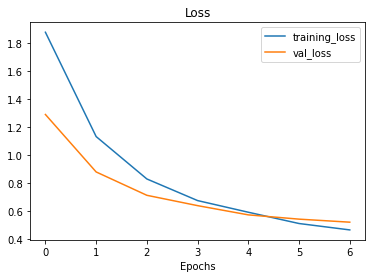

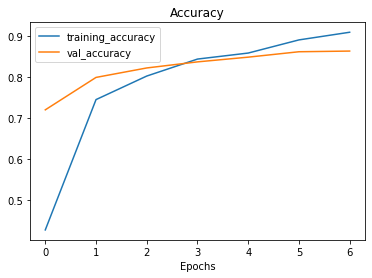

In [ ]:
# Checkout our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? 

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

#create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


we can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-08-07 19:37:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c02::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   225MB/s    in 0.6s    

2021-08-07 19:37:06 (225 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [ ]:
# Setup Dataloaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 🤔 **Note:** At the time of writing, the preprocessing layers we're using for data augmentation are in *experimental* status within the in TensorFlow library. This means although the layers should be considered stable, the code may change slightly in a future version of TensorFlow. For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts image height by a specified amount.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts image width by a specified amount.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

There are more option but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescale(1./255) # Keep for models like Resnet50V2 but EfficientNet's have rescale built-in
], name="data_augmentation")


#Visualize our data augmentation layer

10_food_classes_1_percent/train/chicken_wings/2672056.jpg


(-0.5, 477.5, 511.5, -0.5)

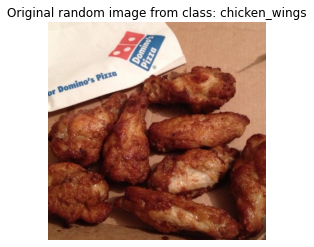

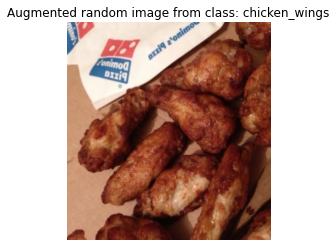

In [ ]:
# View a random image and compare it to its augmentated version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read in random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_image = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.0)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

# Feature extraction transfer learning on 1% of data with data augmentation


In [ ]:
# Setup the input shape and the base model, freezing the base model layer
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation Sequencial model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and the outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=7,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps= int(len(test_data)*0.25),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_aug")]
                                )


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210807-193710


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/7
3/3 [==============================] - 11s 3s/step - loss: 2.4195 - accuracy: 0.0714 - val_loss: 2.2411 - val_accuracy: 0.1431
Epoch 2/7
3/3 [==============================] - 4s 2s/step - loss: 2.1372 - accuracy: 0.1286 - val_loss: 2.1176 - val_accuracy: 0.2467
Epoch 3/7
3/3 [==============================] - 4s 2s/step - loss: 1.9618 - accuracy: 0.3286 - val_loss: 1.9975 - val_accuracy: 0.3306
Epoch 4/7
3/3 [==============================] - 3s 1s/step - loss: 1.8140 - accuracy: 0.5143 - val_loss: 1.9086 - val_accuracy: 0.4128
Epoch 5/7
3/3 [==============================] - 4s 2s/step - loss: 1.6247 - accuracy: 0.6143 - val_loss: 1.8069 - val_accuracy: 0.4770
Epoch 6/7
3/3 [==============================] - 4s 2s/step - loss: 1.5323 - accuracy: 0.7000 - val_loss: 1.7413 - val_accuracy: 0.4951
Epoch 7/7
3/3 [==============================] - 4s 2s/step - loss: 1.4209 - accuracy: 0.7571 - val_loss: 1.6815 - val_accuracy: 0.5049


In [ ]:
# Checkout the model summary 
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate the full test dataset
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 9s 107ms/step - loss: 1.6558 - accuracy: 0.5348


[1.6558339595794678, 0.5347999930381775]

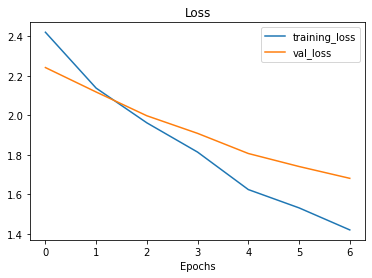

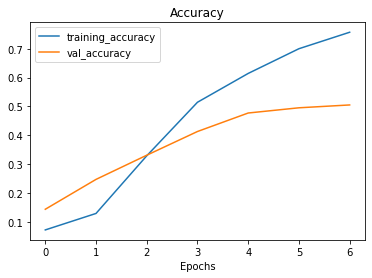

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

> 🤔 **Question:** How do you know what experiments to run?

Great question. 

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
],name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="Global_average_pooling_2D")(x)
outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

#Compile
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,# set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch",## save every epoch
                                                         verbose=1)

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210807-193805
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 597ms/step - loss: 1.9901 - accuracy: 0.3160 - val_loss: 1.5122 - val_accuracy: 0.6299

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 10s 410ms/step - loss: 1.3770 - accuracy: 0.6453 - val_loss: 1.0666 - val_accuracy: 0.7648

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 10s 408ms/step - loss: 1.0707 - accuracy: 0.7427 - val_loss: 0.8763 - val_accuracy: 0.7862

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 403ms/step - loss: 0.8816 - accuracy: 0.7827 - val_loss: 0.7782 - val_accuracy: 0.7944

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 10s 396ms/step - loss: 0.8139 - accuracy: 0.7800 - val_

In [ ]:
#What were model_0 rsults
model_0.evaluate(test_data)

79/79 [==============================] - 10s 110ms/step - loss: 0.5457 - accuracy: 0.8460


[0.5456870198249817, 0.8460000157356262]

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 109ms/step - loss: 0.6912 - accuracy: 0.8180


[0.6911585927009583, 0.8180000185966492]

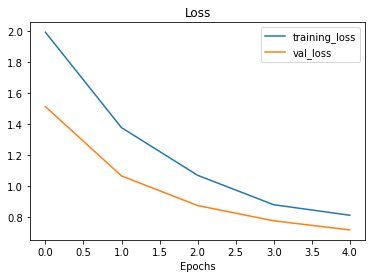

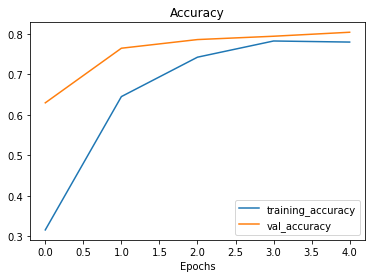

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 109ms/step - loss: 0.6912 - accuracy: 0.8180


Now let's compare the results of our previously trained model and the loaded model. These results should very close if not exactly the same. The reason for minor differences comes down to the precision level of numbers calculated.

In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

If the above cell doesn't output `True`, it's because the numbers are close but not the *exact* same (due to how computers store numbers with degrees of precision).

However, they should be *very* close...

In [ ]:
results_10_percent_data_aug

[0.6911585927009583, 0.8180000185966492]

In [ ]:
loaded_weights_model_results

[0.6911588311195374, 0.8180000185966492]

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-2.38418579e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layers, layer.trainable)

<module 'tensorflow.keras.layers' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/layers/__init__.py'> True
<module 'tensorflow.keras.layers' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/layers/__init__.py'> True
<module 'tensorflow.keras.layers' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/layers/__init__.py'> False
<module 'tensorflow.keras.layers' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/layers/__init__.py'> True
<module 'tensorflow.keras.layers' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/layers/__init__.py'> True


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# How many trainable models in our base model
print(len(model_2.layers[2].trainable_variables))

0


Beautiful. This is exactly what we're after. 

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> 🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

> 🤔 **Question:** Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

> 🔑 **Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

How many trainable variables do we have now?

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
len(model_2.trainable_variables)

12

Wonderful, it looks like our model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://keras.rstudio.com/reference/fit.html) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps=int(0.25* len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")] # name experiment appropriately
                                               )


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210807-193948
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 510ms/step - loss: 0.6976 - accuracy: 0.7867 - val_loss: 0.5975 - val_accuracy: 0.8109
Epoch 6/10
24/24 [==============================] - 10s 392ms/step - loss: 0.5589 - accuracy: 0.8320 - val_loss: 0.5280 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 9s 366ms/step - loss: 0.5107 - accuracy: 0.8373 - val_loss: 0.5362 - val_accuracy: 0.8191
Epoch 8/10
24/24 [==============================] - 9s 360ms/step - loss: 0.4483 - accuracy: 0.8560 - val_loss: 0.5305 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 9s 379ms/step - loss: 0.4247 - accuracy: 0.8787 - val_loss: 0.4900 - val_accuracy: 0.8289
Epoch 10/10
24/24 [==============================] - 9s 356ms/step - loss: 0.3933 - accuracy: 0.8720 - val_loss: 0.5194 - val_accuracy: 0.8224


In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 0.4737 - accuracy: 0.8436


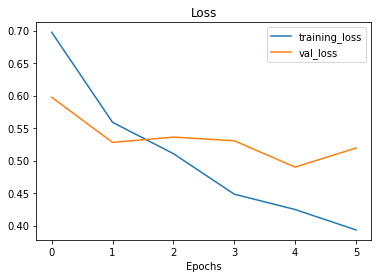

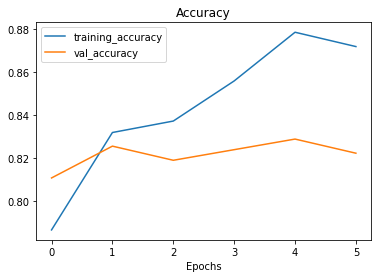

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [ ]:
# Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3160000145435333, 0.6453333497047424, 0.7426666617393494, 0.7826666831970215, 0.7799999713897705, 0.7866666913032532, 0.8320000171661377, 0.8373333215713501, 0.8560000061988831, 0.8786666393280029, 0.871999979019165]


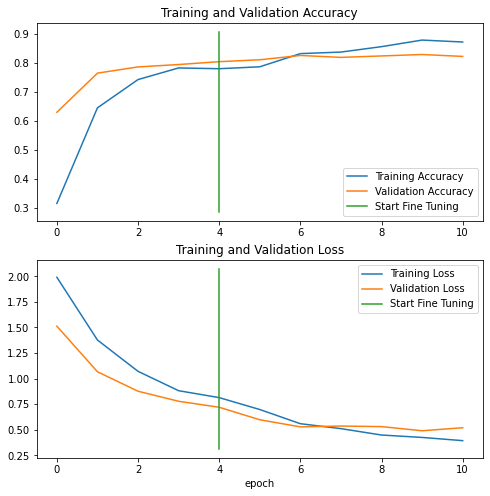

In [ ]:
compare_history(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir_all_data = "10_food_classes_all_data/test/"

--2021-08-07 19:49:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.199.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   242MB/s    in 2.0s    

2021-08-07 19:49:04 (242 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [ ]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 109ms/step - loss: 0.4737 - accuracy: 0.8436


[0.4736994504928589, 0.8435999751091003]

In [ ]:
results_fine_tune_10_percent

[0.47369951009750366, 0.8435999751091003]

Now we'll revert the model back to the saved weights.

In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.6912 - accuracy: 0.8180


[0.6911587119102478, 0.8180000185966492]

In [ ]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6911585927009583, 0.8180000185966492]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_num, layer in enumerate(model_2.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 Global_average_pooling_2D True
4 output_layer True


In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Looking good! The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

Do you remember what it is?

I'll give you a hint. We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!

This will be just as before.

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback("transfer_learning", 
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210807-203917
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 52s 198ms/step - loss: 0.7295 - accuracy: 0.7671 - val_loss: 0.4520 - val_accuracy: 0.8438
Epoch 6/10
235/235 [==============================] - 58s 246ms/step - loss: 0.5933 - accuracy: 0.8044 - val_loss: 0.3924 - val_accuracy: 0.8618
Epoch 7/10
235/235 [==============================] - 53s 224ms/step - loss: 0.5277 - accuracy: 0.8305 - val_loss: 0.3480 - val_accuracy: 0.8914
Epoch 8/10
235/235 [==============================] - 51s 214ms/step - loss: 0.4869 - accuracy: 0.8415 - val_loss: 0.3272 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 48s 203ms/step - loss: 0.4454 - accuracy: 0.8605 - val_loss: 0.3526 - val_accuracy: 0.8914
Epoch 10/10
235/235 [==============================] - 48s 201ms/step - loss: 0.4234 - accuracy: 0.8643 - val_loss: 0.3147 - val_accuracy: 0.8964


In [ ]:
!nvidia-smi

Sat Aug  7 20:55:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   4828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> 🔑 **Note:** Training took longer per epoch, but that makes sense because we're using 10x more training data than before.

Let's evaluate on all of the test data.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 9s 109ms/step - loss: 0.3086 - accuracy: 0.9020


In [ ]:
# How did fine-tuning go with more data?
compare_history(original_history=history_10_percent_data_aug,
                new_history=results_fine_tune_full_data,
                initial_epochs=5)

5


AttributeError: ignored

5
11
[0.3160000145435333, 0.6453333497047424, 0.7426666617393494, 0.7826666831970215, 0.7799999713897705, 0.7670666575431824, 0.8044000267982483, 0.8305333256721497, 0.8414666652679443, 0.8605333566665649, 0.8642666935920715]


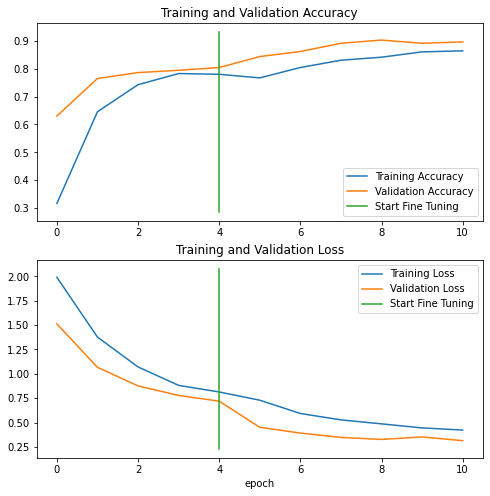

In [ ]:
# How did fine-tuning go with more data?
compare_history(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`, we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the `tensorboard dev upload` command and passing it the directory where our experiments have been logged.

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varing amount of data and fine tuning." \
  --one_shot # exits the uploader when upload has finished



### My tensorboard experiments are availabel at https://tensorboard.dev/experiment/cwDcbbeuQq2NGOVdV7uWGw/

To find all of your previous TensorBoard.dev experiments using the command `tensorboard dev list`.

In [ ]:
# View previous experiments
!tensorboard dev list

2021-08-07 21:31:14.825313: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/cwDcbbeuQq2NGOVdV7uWGw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varing amount of data and fine tuning.
	Id                   cwDcbbeuQq2NGOVdV7uWGw
	Created              2021-08-07 21:18:35 (12 minutes ago)
	Updated              2021-08-07 21:18:40 (12 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              186
	Tensor bytes         0
	Binary object bytes  4220654
https://tensorboard.dev/experiment/sqeg0IawSpqt6cWliZHYbw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   sqeg0IawSpqt6cWliZHYbw
	Created              2021-06-2

And if you want to remove a previous experiment (and delete it from public viewing) you can use the command:

```
tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID_TO_DELETE]```

In [ ]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id sqeg0IawSpqt6cWl*******